# Chuẩn bị

## Tải dữ liệu từ Kaggle

In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoanduynguyntrn","key":"15c5cbb33e8e9c6f679cf6d7bb59902e"}'}

In [ ]:
!mkdir ~/.kaggle
 
! cp kaggle.json ~/.kaggle/
 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
ls

kaggle.json  sample_data/


In [ ]:
! kaggle datasets download -d mlg-ulb/creditcardfraud

 89% 59.0M/66.0M [00:00<00:00, 61.5MB/s]
100% 66.0M/66.0M [00:00<00:00, 96.2MB/s]


In [ ]:
! unzip creditcardfraud.zip 

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


## Import thư viện

In [57]:
# Utils
import numpy as np
from collections import Counter
import pandas as pd
from random import randint
import math 

# Sampling, metrics 
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import neighbors, datasets, impute
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, plot_roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold

# For plotting 
import itertools
import matplotlib.pyplot as plt
 
# For preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from scipy.spatial import distance
from scipy.stats import chi2

# Định nghĩa hàm 

## Biểu đồ phân phối các nhãn 

In [90]:
# Plotting some features 
def plot(X_train, y_train):
  counter = Counter(y_train)
  print(counter)

  grid = plt.GridSpec(2, 2, wspace=0.5, hspace=0.7)
  plt.subplot(grid[0,0])
  for label, _ in counter.items():
    row_ix = np.where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
  plt.xlabel('V1')
  plt.ylabel('V2')
  plt.legend()

  plt.subplot(grid[0,1])
  for label, _ in counter.items():
    row_ix = np.where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 2], X_train[row_ix, 3], label=str(label))
  plt.xlabel('V3')
  plt.ylabel('V4')
  plt.legend()

  plt.subplot(grid[1,0])
  for label, _ in counter.items():
    row_ix = np.where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 4], X_train[row_ix, 5], label=str(label))
  plt.xlabel('V5')
  plt.ylabel('V6')
  plt.legend()

  plt.subplot(grid[1,1])
  plt.bar(list(map(str, counter.keys())), counter.values())
  plt.title('Class distribution')
  plt.show()

## Cross-validation

In [9]:
def cross_validation(X, y):
  # Split training set to 10 folds
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
  
  precision = []
  recall = []
  error = []
  fbeta = []
  krange = range(1,11)
  for i in krange:
    TN, FP, FN, TP = 0, 0, 0, 0
    for train, test in kfold.split(X, y): 
      knn = neighbors.KNeighborsClassifier(n_neighbors = i, p=2, weights='distance', n_jobs=6)
      knn.fit(X[train], y[train])
      pred_i = knn.predict(X[test])

      cm = confusion_matrix(y[test], pred_i)
      tn, fp, fn, tp = cm.ravel()
      TN += tn
      FP += fp
      FN += fn
      TP += tp
    precision += [TP/(TP+FP)]
    recall += [TP/(TP+FN)]
    error += [(FN+FP)/(TN+FP+FN+TP)]
    fbeta += [fb_score(TP/(TP+FP), TP/(TP+FN), 2)]
    print(f"k={i}\nprecision: {precision[-1]}\nrecall: {recall[-1]}\nerror: {error[-1]}\nfbeta: {fbeta[-1]}")
  # Plotting
  plt.figure(figsize =(10, 6))
  grid = plt.GridSpec(2, 1, wspace=0.2, hspace=0.4)
 
  plt.subplot(grid[0,0])
  plot_conf = {'linestyle': 'dashed', 'marker': 'o', 'markerfacecolor': 'red', 'markersize': 10}
  plt.plot(krange, precision, color ='blue', label='precision', **plot_conf)
  plt.plot(krange, recall, color ='orange', label='recall', **plot_conf)
  plt.plot(krange, fbeta, color ='green', label='fbeta', **plot_conf)
  plt.xlabel('K')
  plt.legend()
  
  plt.subplot(grid[1,0])
  plt.plot(krange, error, color ='red', label='error', **plot_conf)
  plt.xlabel('K')
  plt.legend()

  plt.show()

## KNN

In [10]:
def knn_classify(X_train, y_train, k):
 
  # KNN: using euclide distance, weight=1/distance
  clf = neighbors.KNeighborsClassifier(n_neighbors=k, p=2, weights='distance', n_jobs=4)
  clf.fit(X_train, y_train)
 
  y_pred = clf.predict(X_test)
  y_score = clf.predict_proba(X_test)
 
  fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

  auc_s = roc_auc_score(y_test, y_score[:, 1])
 
  cm = confusion_matrix(y_test, y_pred)
 
  tn, fp, fn, tp = cm.ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  fb = fb_score(precision, recall, 2)
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'f_2 score: {fb}')
 
  err = 1 - accuracy_score(y_test, y_pred)
 
  # Evaluation
  grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.2)
 
  plt.subplot(grid[0,0])
  plt.plot(fpr, tpr, 'b', marker='.', label='AUC = %0.2f'%auc_s)
  plt.plot([0,1], [0,1], linestyle='--')
  plt.legend()
 
  plt.subplot(grid[0,1])
  plot_confusion_matrix(cm=cm, classes=[0,1], normalize=False)
 
  plt.show()

## Plot confusion matrix 

In [11]:
# Plot confusion matrix (Hao)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Hàm tính f_beta score

In [12]:
def fb_score(precision, recall, beta):
  return (1 + beta**2)/(1/precision + (beta**2)/recall)

In [13]:
data = pd.read_csv('creditcard.csv')

# Khai phá tập dữ liệu

## Đọc dữ liệu

In [14]:
data = pd.read_csv('creditcard.csv')

In [15]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [20]:
inputs, outputs = data.iloc[:, 0:30], data.iloc[:, 2]
print(" \nCount total NaN at each column in a DataFrame : \n\n", data.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


## Tách dữ liệu

In [ ]:
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

# Set stratify=y to make the distribution of classes in test set is similar to one in the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, stratify=y)

## Tiền xử lý dữ liệu

In [32]:
# Outliers deletion (Duy Anh)
## Detech outliers
## Calculate Mahalanobis distance 
df = pd.DataFrame(X_train)
cov = np.cov(df.values.T)
inv_covmat = np.linalg.inv(cov)
mean = np.mean(X_train, axis=0)
mahalanobis = [0] * len(X_train)
for i in range(len(df.index)):
  mahalanobis[i] = distance.mahalanobis(X_train[i], mean, inv_covmat)
df.insert(29, "mahalanobis", mahalanobis, True)
## Calculate p-value for each mahalanobis distance 
df['p'] = 1 - chi2.cdf(df['mahalanobis'], 28)
df.head()
outlier_index_lst = pd.Series(df['p']).where(lambda x : x < 0.001).dropna().index.values
print('Outlier:', outlier_index_lst)
## Delete outliers from dataset
X_train = np.delete(X_train, outlier_index_lst, 0)
y_train = np.delete(y_train, outlier_index_lst, 0)
 
# Scaling data (Duy Anh)
scaler = MinMaxScaler(feature_range=(-5, 5))
scaler.fit(X_train)
scaler.fit(X_test)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

Outlier: [   838  21276  25348  32115  34827  42105  46676  53308  56268  64140
  64651  65820  69532  72111  73226  83257  85498  86550  87038  90084
 108795 110279 111605 113078 117738 120651 122489 127348 127729 128475
 128621 135532 140103 140789 141093 142655 142748 153164 154054 158910
 159879 161555 163060 167964 175422 176959 179019 182024 185528 187505
 198998]


# Phân lớp dữ liệu trước khi lấy mẫu

Counter({0: 198976, 1: 337})


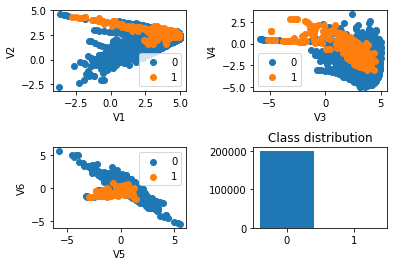

Counter({0: 85295, 1: 148})


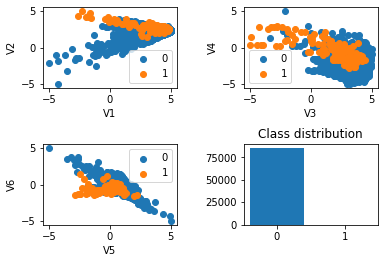

In [91]:
plot(X_train[:], y_train[:])
plot(X_test, y_test)

k=1
precision: 0.8338762214983714
recall: 0.7596439169139466
error: 0.0006622749143307261
fbeta: 0.7734138972809668
k=2
precision: 0.8338762214983714
recall: 0.7596439169139466
error: 0.0006622749143307261
fbeta: 0.7734138972809668
k=3
precision: 0.9309090909090909
recall: 0.7596439169139466
error: 0.0005017234199475197
fbeta: 0.7886629698089956
k=4
precision: 0.9309090909090909
recall: 0.7596439169139466
error: 0.0005017234199475197
fbeta: 0.7886629698089956
k=5
precision: 0.9296296296296296
recall: 0.744807121661721
error: 0.0005268095909448957
fbeta: 0.7756489493201483
k=6
precision: 0.9333333333333333
recall: 0.7477744807121661
error: 0.0005167751225459453
fbeta: 0.7787391841779975
k=7
precision: 0.9330855018587361
recall: 0.744807121661721
error: 0.0005217923567454205
fbeta: 0.7761286332714904
k=8
precision: 0.9296296296296296
recall: 0.744807121661721
error: 0.0005268095909448957
fbeta: 0.7756489493201483
k=9
precision: 0.9304029304029304
recall: 0.7537091988130564
error: 0.00051

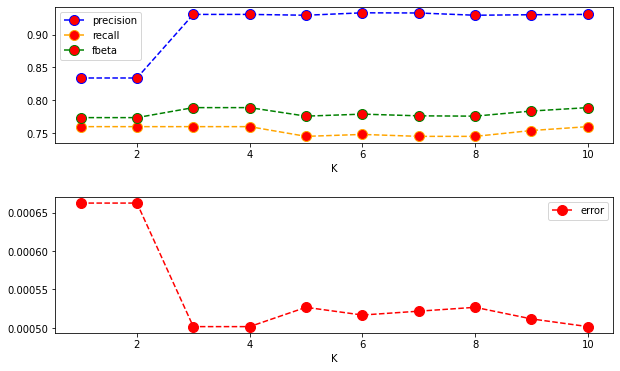

In [48]:
cross_validation(X_train[:], y_train[:])

Precision: 0.952
Recall: 0.8040540540540541
f_beta score: 0.8298465829846583


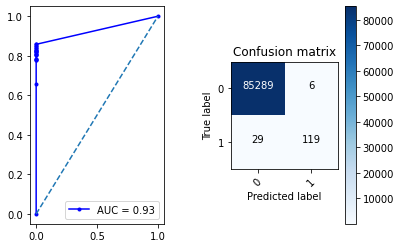

In [85]:
knn_classify(X_train[:], y_train[:], 4)

# Phân lớp dữ liệu sau khi lấy mẫu

## Random undersampling


In [50]:
def randomUnderSample(X_train, y_train, rate=1):
  resampled = []
  sizeMajor = 0
  counter = Counter(y_train)
  for label, size in counter.items():
    if label == 0: continue 
    row_ix = np.where(y_train == label)[0]
    resampled += [(X_train[i],y_train[i]) for i in row_ix]
    sizeMajor += size
   
  sizeMajor *= rate 
  row_ix = np.where(y_train == 0)[0]
  while sizeMajor > 0:
    ix = np.random.randint(row_ix.size)
    i = row_ix[ix]
    row_ix = np.delete(row_ix, ix)
    resampled.append((X_train[i],y_train[i]))
    sizeMajor -= 1

  np.random.shuffle(resampled)
  X_resample = np.array([resampled[i][0] for i in range(len(resampled))])
  y_resample = np.array([resampled[i][1] for i in range(len(resampled))])
  return X_resample, y_resample

In [51]:
X1, y1= randomUnderSample(X_train[:], y_train[:])

Counter({1: 337, 0: 337})


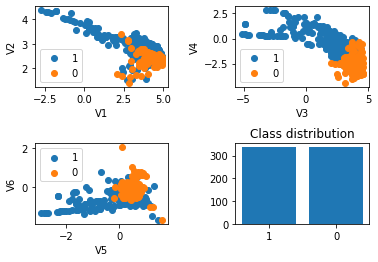

In [92]:
plot(X1, y1)

k=1
precision: 0.9435736677115988
recall: 0.8931750741839762
error: 0.08011869436201781
fbeta: 0.9028194361127774
k=2
precision: 0.9435736677115988
recall: 0.8931750741839762
error: 0.08011869436201781
fbeta: 0.9028194361127774
k=3
precision: 0.99
recall: 0.8813056379821959
error: 0.06379821958456973
fbeta: 0.9010922330097086
k=4
precision: 0.9866220735785953
recall: 0.8753709198813057
error: 0.06824925816023739
fbeta: 0.8955676988463874
k=5
precision: 0.9867109634551495
recall: 0.8813056379821959
error: 0.06528189910979229
fbeta: 0.9005457853244391
k=6
precision: 0.9899665551839465
recall: 0.8783382789317508
error: 0.06528189910979229
fbeta: 0.8986035215543412
k=7
precision: 0.9866220735785953
recall: 0.8753709198813057
error: 0.06824925816023739
fbeta: 0.8955676988463874
k=8
precision: 0.98989898989899
recall: 0.8724035608308606
error: 0.06824925816023739
fbeta: 0.8936170212765958
k=9
precision: 0.9931972789115646
recall: 0.8664688427299704
error: 0.06973293768545995
fbeta: 0.8891595

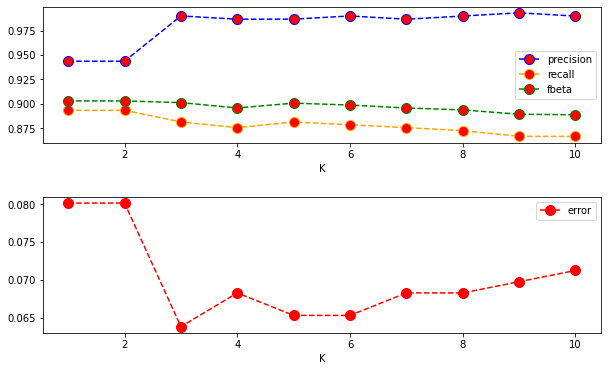

In [53]:
cross_validation(X1, y1)

Precision: 0.04543935850317407
Recall: 0.918918918918919
f_beta score: 0.1896792189679219


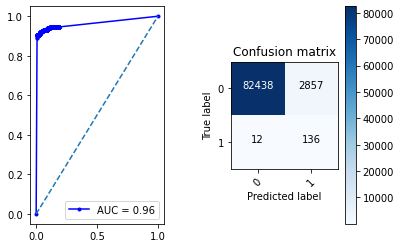

In [99]:
# Classification using self-implemented random under sampling
knn_classify(X1, y1, 3)

## Near Miss Undersampling
Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.

There are three versions of the technique, named NearMiss-1, NearMiss-2, and NearMiss-3.

Nearmiss-1: chọn ra những majority class có trung bình tổng khoảng cách gần nhất với k hàng xóm là minor class xung quanh.

Nearmiss-2: chọn ra những majority class có trung bình tổng khoảng cách xa nhất với k hàng xóm là minor class xung quanh.

Nearmiss-3: chọn ra những majority class có trung bình tổng khoảng cách gần nhất với tất cả hàng xóm là minor class xung quanh.

In [58]:
def nearMiss(X_train, y_train, version=1, n_neighbors=3):
  counter = Counter(y_train)
  resampled = []
  X_train_minor = []
  sizeMajor = 0
  for label, size in counter.items():
    if(label == 0): continue
    row_ix = np.where(y_train == label)[0]
    resampled += [(X_train[i],y_train[i]) for i in row_ix]
    X_train_minor += [X_train[i] for i in row_ix]
    sizeMajor += size
  row_ix_major = np.where(y_train == 0)[0]
  topMajorNeighbors = []
  for i in row_ix_major:
    tempAver = averClosetDistance(X_train[i], X_train_minor, version, n_neighbors)
    topMajorNeighbors.append((X_train[i], y_train[i], tempAver))
  topMajorNeighbors.sort(key=lambda x: x[2])
  resampled += [(i[0], i[1]) for i in topMajorNeighbors[0: sizeMajor]]
  np.random.shuffle(resampled)
  X_resample = np.array([resampled[i][0] for i in range(len(resampled))])
  y_resample = np.array([resampled[i][1] for i in range(len(resampled))])
  return X_resample, y_resample

def averClosetDistance(point1, X, version, n_neighbors):
    ls = [euclidean_distance(point1, point) for point in X]
    ls.sort()
    aver = 0
    if version == 1:
      aver = sum(ls[0:n_neighbors])/n_neighbors 
    elif version == 2:
      aver = sum(ls[-n_neighbors:])/n_neighbors 
    elif version == 3:
      aver = sum(ls)/len(ls) 
    return aver

def euclidean_distance(point1, point2):
    sum_squared_distance = 0
    for i in range(len(point1)):
        sum_squared_distance += math.pow(point1[i] - point2[i], 2)
    return math.sqrt(sum_squared_distance)

In [59]:
#Near miss 1 with 3 neighbors
X2, y2 = nearMiss(X_train[:], y_train[:], 1, 3)

Counter({1: 337, 0: 337})


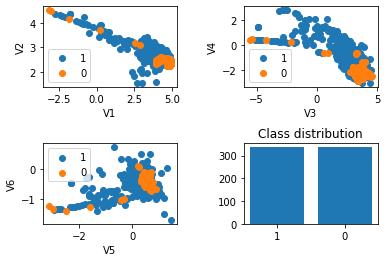

In [93]:
plot(X2, y2)

k=1
precision: 0.9525316455696202
recall: 0.8931750741839762
error: 0.07566765578635015
fbeta: 0.9044471153846153
k=2
precision: 0.9525316455696202
recall: 0.8931750741839762
error: 0.07566765578635015
fbeta: 0.9044471153846153
k=3
precision: 0.9701986754966887
recall: 0.8694362017804155
error: 0.07863501483679525
fbeta: 0.8878787878787879
k=4
precision: 0.98
recall: 0.8724035608308606
error: 0.07270029673590504
fbeta: 0.8919902912621359
k=5
precision: 0.9765100671140939
recall: 0.8635014836795252
error: 0.07863501483679525
fbeta: 0.8839611178614823
k=6
precision: 0.973421926910299
recall: 0.8694362017804155
error: 0.0771513353115727
fbeta: 0.8884172225591267
k=7
precision: 0.9735099337748344
recall: 0.8724035608308606
error: 0.07566765578635015
fbeta: 0.8909090909090909
k=8
precision: 0.9735099337748344
recall: 0.8724035608308606
error: 0.07566765578635015
fbeta: 0.8909090909090909
k=9
precision: 0.9731543624161074
recall: 0.8605341246290801
error: 0.08160237388724036
fbeta: 0.8809234

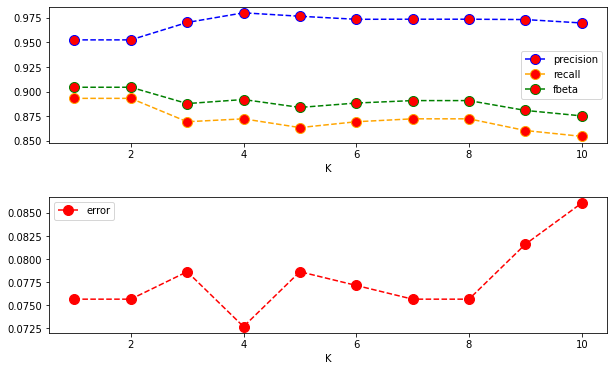

In [61]:
cross_validation(X2, y2)

Precision: 0.008134425840161502
Recall: 0.9256756756756757
f_beta score: 0.03929104049558335


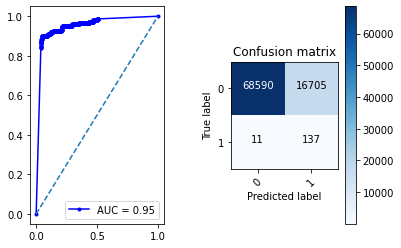

In [100]:
# Classification using self-implemented near miss under sampling
knn_classify(X2, y2, 4)

In [63]:
#Near miss 2 with 3 neighbors
X3, y3 = nearMiss(X_train[:], y_train[:], 2, 3)

Counter({0: 337, 1: 337})


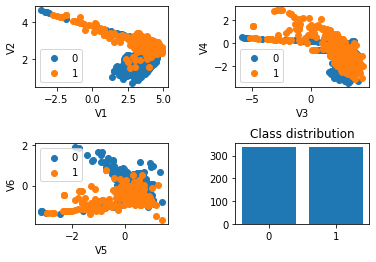

In [94]:
plot(X3, y3)

k=1
precision: 0.9230769230769231
recall: 0.9258160237388724
error: 0.07566765578635015
fbeta: 0.9252669039145909
k=2
precision: 0.9230769230769231
recall: 0.9258160237388724
error: 0.07566765578635015
fbeta: 0.9252669039145909
k=3
precision: 0.9237536656891495
recall: 0.9347181008902077
error: 0.0712166172106825
fbeta: 0.9325044404973356
k=4
precision: 0.9266862170087976
recall: 0.9376854599406528
error: 0.06824925816023739
fbeta: 0.93546477205447
k=5
precision: 0.9181286549707602
recall: 0.9317507418397626
error: 0.07566765578635015
fbeta: 0.9289940828402365
k=6
precision: 0.924198250728863
recall: 0.9406528189910979
error: 0.06824925816023739
fbeta: 0.9373151981076286
k=7
precision: 0.9203539823008849
recall: 0.9258160237388724
error: 0.0771513353115727
fbeta: 0.9247184350918791
k=8
precision: 0.9237536656891495
recall: 0.9347181008902077
error: 0.0712166172106825
fbeta: 0.9325044404973356
k=9
precision: 0.9183673469387755
recall: 0.9347181008902077
error: 0.07418397626112759
fbeta:

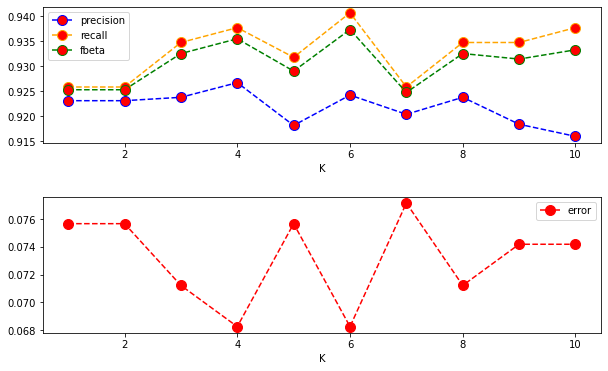

In [65]:
cross_validation(X3, y3)

Precision: 0.0020726322429485446
Recall: 0.9324324324324325
f_beta score: 0.010271831363325096


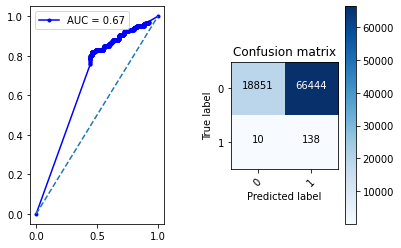

In [104]:
# Classification using self-implemented near miss under sampling
knn_classify(X3, y3, 4)

In [67]:
#Near miss 3 with all neighbors
X4, y4 = nearMiss(X_train[:], y_train[:], 3)

Counter({1: 337, 0: 337})


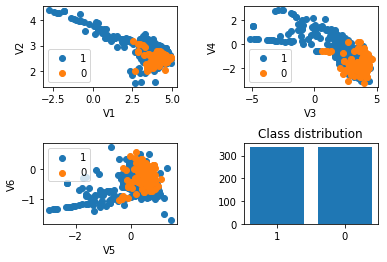

In [96]:
plot(X4, y4)

k=1
precision: 0.9455128205128205
recall: 0.8753709198813057
error: 0.08753709198813056
fbeta: 0.8885542168674698
k=2
precision: 0.9455128205128205
recall: 0.8753709198813057
error: 0.08753709198813056
fbeta: 0.8885542168674698
k=3
precision: 0.9421221864951769
recall: 0.8694362017804155
error: 0.09198813056379822
fbeta: 0.8830620855937312
k=4
precision: 0.9419354838709677
recall: 0.8664688427299704
error: 0.09347181008902077
fbeta: 0.8805790108564536
k=5
precision: 0.9260450160771704
recall: 0.8545994065281899
error: 0.10682492581602374
fbeta: 0.867992766726944
k=6
precision: 0.9258064516129032
recall: 0.8516320474777448
error: 0.1083086053412463
fbeta: 0.8655006031363088
k=7
precision: 0.921311475409836
recall: 0.8338278931750742
error: 0.11869436201780416
fbeta: 0.8499697519661222
k=8
precision: 0.922077922077922
recall: 0.8427299703264095
error: 0.1142433234421365
fbeta: 0.8574879227053139
k=9
precision: 0.9218241042345277
recall: 0.8397626112759644
error: 0.11572700296735905
fbeta

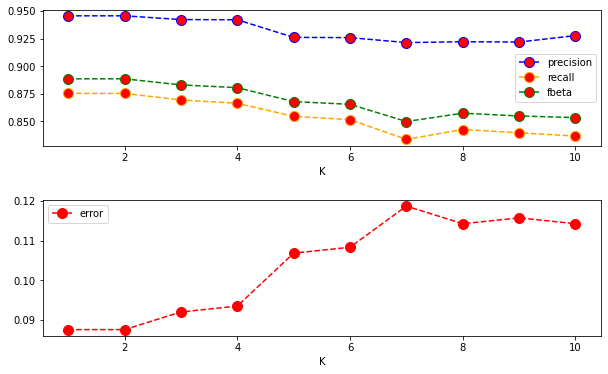

In [69]:
cross_validation(X4, y4)

Precision: 0.0041550367926922105
Recall: 0.8851351351351351
f_beta score: 0.02039227895392279


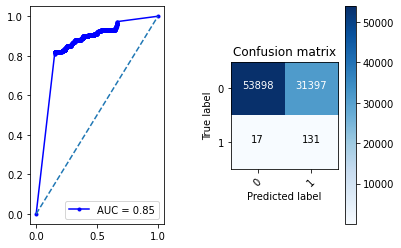

In [70]:
# Classification using self-implemented near miss under sampling
knn_classify(X4, y4, 3)

## Random oversampling

In [71]:
def randomOverSample(X_train, y_train, rate=1):
  resampled = [(X_train[i],y_train[i]) for i in range(y_train.size)]
  counter = Counter(y_train)
  sizeMajor = counter[0]
  for label, size in counter.items():
    if label == 0: continue 
    row_ix = np.where(y_train == label)[0]
    while size < sizeMajor*rate:
      i = np.random.choice(row_ix)
      resampled.append((X_train[i],y_train[i]))
      size += 1
  np.random.shuffle(resampled)
  X_resample = np.array([resampled[i][0] for i in range(len(resampled))])
  y_resample = np.array([resampled[i][1] for i in range(len(resampled))])
  return X_resample, y_resample

In [72]:
X5, y5 = randomOverSample(X_train[:], y_train[:])

Counter({1: 198976, 0: 198976})


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


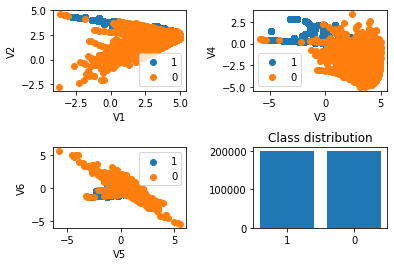

In [95]:
plot(X5, y5)

k=1
precision: 0.9997387302289125
recall: 1.0
error: 0.0001306690254100997
fbeta: 0.9999477351215962
k=2
precision: 0.9997387302289125
recall: 1.0
error: 0.0001306690254100997
fbeta: 0.9999477351215962
k=3
precision: 0.9995478886399486
recall: 1.0
error: 0.00022615792859440335
fbeta: 0.9999095450114074
k=4
precision: 0.9995127415571172
recall: 1.0
error: 0.00024374798970730138
fbeta: 0.9999025103092836
k=5
precision: 0.9993069296985646
recall: 1.0
error: 0.00034677549051141844
fbeta: 0.9998613090416455
k=6
precision: 0.9992768179991964
recall: 1.0
error: 0.0003618526857510454
fbeta: 0.9998552798726462
k=7
precision: 0.9991313036972317
recall: 1.0
error: 0.00043472579607590865
fbeta: 0.9998261399141553
k=8
precision: 0.9990911692785089
recall: 1.0
error: 0.0004548287230620778
fbeta: 0.9998181016038212
k=9
precision: 0.9990008786243253
recall: 1.0
error: 0.0005000603087809585
fbeta: 0.9998000158781364
k=10
precision: 0.9989306638418788
recall: 1.0
error: 0.0005352404310067546
fbeta: 0.99

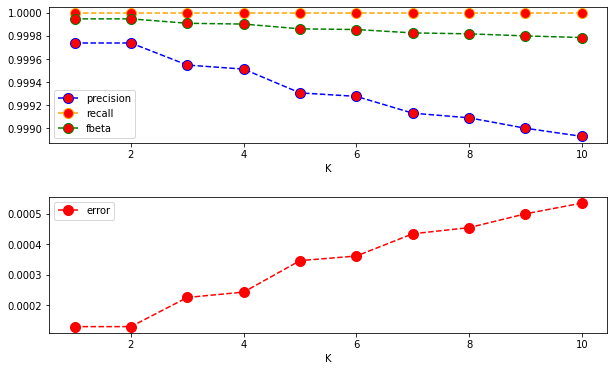

In [74]:
cross_validation(X5, y5)

Precision: 0.8613138686131386
Recall: 0.7972972972972973
f_beta score: 0.8093278463648834


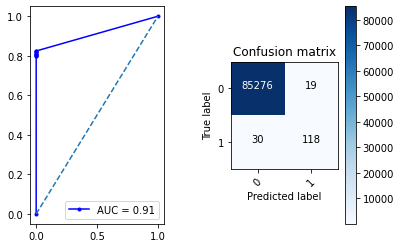

In [75]:
# Classification using self-implemented random over sampling
knn_classify(X5, y5, 2)

## SMOTE sampling

In [76]:
from math import log, ceil
import random as rd
def smote(X, y, n_neighbors, r_after):
  # Find major, minor class
  counter = Counter(y)
  major_class, M, minor_class, m = np.array(counter.most_common()).ravel()
  # Calculate some parameters for sampling
  r = m/M
  n_loops = ceil((r_after/r - 1)) 
  n_examples = ceil(r_after*M - m)
  X_minor = X[y==minor_class]
  # Fit KNN to minor set
  knn = neighbors.NearestNeighbors(n_neighbors=n_neighbors + 1, p=2)
  knn.fit(X_minor)
  X_new = []
  # Sampling
  while n_loops > 0:
    for x in X_minor:
      if n_examples > 0:
        knearest = knn.kneighbors([x], return_distance = False)
        knearest = knearest[0][1:]
        X_new += generate_examples(x, X_minor[knearest])
        n_examples -= 1
      else: 
        break
    n_loops -= 1
    
  y_new = np.array([minor_class]*len(X_new))
  
  X = np.append(X, X_new, axis=0)
  y = np.append(y, y_new, axis=0)
 
  return X, y
 
def generate_examples(x0, X):
  random_ix = rd.randint(0, len(X) - 1)
  x = X[random_ix]
  r = rd.uniform(0,1)
  new_sample = x0 + r*(x-x0)
  return [new_sample.tolist()]

In [77]:
X6, y6 = smote(X_train[:], y_train[:], 3, 0.8)

Counter({0: 198976, 1: 159181})


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


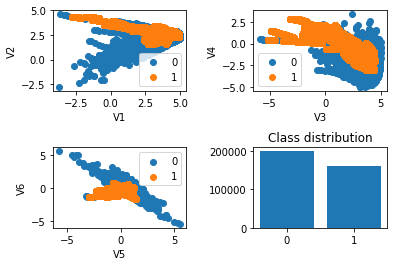

In [97]:
plot(X6, y6)

k=1
precision: 0.9993345345194523
recall: 1.0
error: 0.00029595959313932156
fbeta: 0.9998668360110602
k=2
precision: 0.9993345345194523
recall: 1.0
error: 0.00029595959313932156
fbeta: 0.9998668360110602
k=3
precision: 0.9988704890155057
recall: 1.0
error: 0.0005025728940101687
fbeta: 0.9997738934912729
k=4
precision: 0.9988203477464249
recall: 1.0
error: 0.0005249094670772874
fbeta: 0.9997638466862538
k=5
precision: 0.9983755644756648
recall: 1.0
error: 0.000723146553047965
fbeta: 0.9996746901392175
k=6
precision: 0.9983192117855866
recall: 1.0
error: 0.0007482751977484735
fbeta: 0.9996633897406719
k=7
precision: 0.9979562025491044
recall: 1.0
error: 0.0009102153524850834
fbeta: 0.9995905710779912
k=8
precision: 0.9978561085235358
recall: 1.0
error: 0.0009548884986193206
fbeta: 0.9995704850379341
k=9
precision: 0.9974746841788651
recall: 1.0
error: 0.0011252048682561
fbeta: 0.9994939144150253
k=10
precision: 0.9973621884437538
recall: 1.0
error: 0.001175462157657117
fbeta: 0.999471322

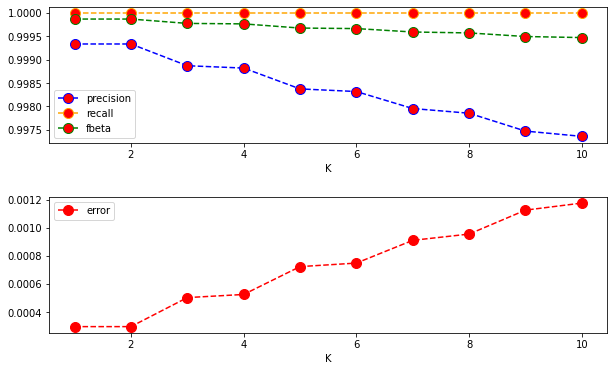

In [79]:
cross_validation(X6[:], y6[:])

Precision: 0.5970873786407767
Recall: 0.831081081081081
f_beta score: 0.7706766917293233


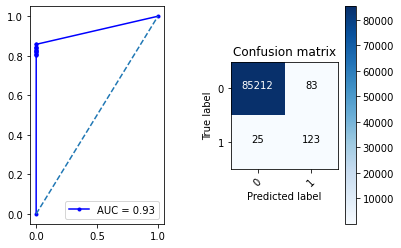

In [80]:
# Classification using self-implemented SMOTE
knn_classify(X6, y6, 3)

## Combine SMOTE with 1 undersampling technique 

In [81]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import OneSidedSelection

def oneSidedSelection(X,y):
  oss = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
  return oss.fit_resample(X,y)

def borderlineSmote(X,y,scale,k,m):
  bls = BorderlineSMOTE(sampling_strategy=scale, k_neighbors=k, m_neighbors=m, kind='borderline-1')
  return bls.fit_resample(X,y)


In [ ]:
X7, y7 = borderlineSmote(X_train, y_train, 0.1, 5, 10)
X7, y7 = oneSidedSelection(X7, y7)

Counter({0: 20510, 1: 19897})


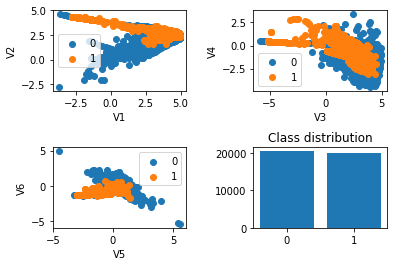

In [98]:
plot(X7, y7)

k=1
precision: 0.9967353088900051
recall: 0.9973865406845253
error: 0.0028955379018486896
fbeta: 0.997256226255804
k=2
precision: 0.9967353088900051
recall: 0.9973865406845253
error: 0.0028955379018486896
fbeta: 0.997256226255804
k=3
precision: 0.9966360395641914
recall: 0.9976378348494748
error: 0.0028212933402628256
fbeta: 0.9974373147078036
k=4
precision: 0.9965858311994779
recall: 0.9975875760164848
error: 0.0028707897146534015
fbeta: 0.997387065976584
k=5
precision: 0.9956861958266453
recall: 0.9976378348494748
error: 0.0032915088969732967
fbeta: 0.9972468952212531
k=6
precision: 0.995586317584512
recall: 0.9976378348494748
error: 0.0033410052713638725
fbeta: 0.9972268552940939
k=7
precision: 0.9949874686716792
recall: 0.9976378348494748
error: 0.003637983517707328
fbeta: 0.9971066326428097
k=8
precision: 0.9945886361358853
recall: 0.9976378348494748
error: 0.0038359690152696313
fbeta: 0.9970265003114137
k=9
precision: 0.9939909864797196
recall: 0.9976378348494748
error: 0.0041329

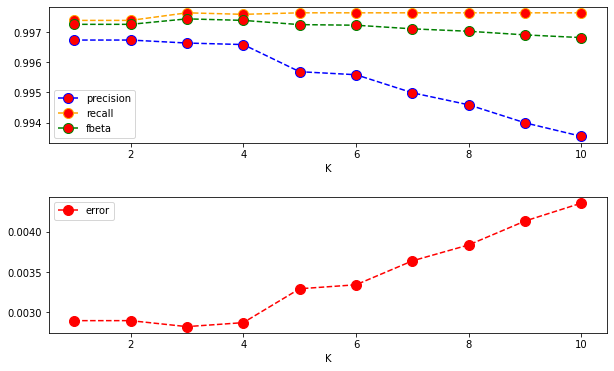

In [83]:
cross_validation(X7, y7)

Precision: 0.8482758620689655
Recall: 0.831081081081081
f_beta score: 0.8344640434192673


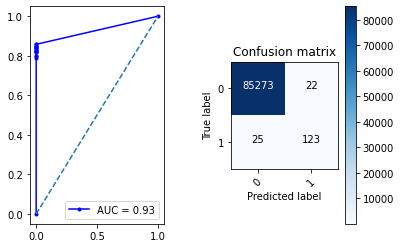

In [84]:
knn_classify(X7, y7, 3)